## Introduction

Black Scholes model is derived using a continuously rebalanced portfolio whose return has no randomness. 
Non-arbitrage condition dictates that this portfolio can only have a short rate of return same as the riskless asset (bond, etc).
Constructing such a portfolio is called delta hedging. 

In this notebook, we are going to demonstrate, with our portfolio optimization tool, 
that the most risk averse portfolio on the efficient frontier is indeed the delta-hedging portfolio.

** Black Scholes formula **

The price of vanilla options is given by the Black-Scholes formula.

Undiscounted put prices:

\begin{equation}
-FN\left(-d_{1}\right)+KN\left(-d_{2}\right),
\end{equation}
where
\begin{eqnarray}
d_{1} & = & \frac{\log\frac{F}{K}+\frac{1}{2}\sigma^{2}\tau}{\sigma\sqrt{\tau}},\\
d_{2} & = & \frac{\log\frac{F}{K}-\frac{1}{2}\sigma^{2}\tau}{\sigma\sqrt{\tau}}.
\end{eqnarray}

$F$ is the forward price of stock, $\tau = T-t$ is time to maturity, $\sigma$ is volatility.
The present value of option is multiplied by a discount factor, which equals to a zero-coupon-bound $P(t, T)$. With constant risk-free rate $r$, we have $P(t, T) = e^{-r(T-t)}$.



In [1]:
from scipy.stats import norm 
import numpy as np
def bs_put(df, fwd, t, vol, k):
    log_fwd_moneyness = np.log(fwd/k)
    d1 = (log_fwd_moneyness + vol**2 /2.0 * t) / vol / np.sqrt(t)
    d2 = d1 - vol * np.sqrt(t)
    return df * (-norm.cdf(-d1) * fwd + norm.cdf(-d2) * k), norm.cdf(-d1)

** Delta hedging **

With stock and its vanilla put option, we can construct an risk-free portfolio. 
Such portfolio consists of one unit of the put option, and $N(-d_1)$ units of the stock. 

Let's use the following market settings to check on the weights of stock and put option.

In [2]:
vol = 0.3
s0 = 10.0
k = 10.0
t = 2.0
r = 0.2 # riskless return

put_now, hedge = bs_put(np.exp(-r*t), s0*np.exp(r*t), t, vol, k)
w_stock_delta_hedging = s0*hedge/(s0*hedge+put_now)
w_put_delta_hedging = 1.0 - w_stock_delta_hedging
print("Weight of stock in delta hedging portfolio: "+str(w_stock_delta_hedging))
print("Weight of put option in delta hedging portfolio: " + str(w_put_delta_hedging))

Weight of stock in delta hedging portfolio: 0.796047657326
Weight of put option in delta hedging portfolio: 0.203952342674


** Construct efficient frontier based on return in infinitesimal future time $\mathrm{d}t$ **

We model the stock process using Geometric Brownian motion, with drift $r_p$ different than the risk free rate $r$.
We construct the efficient frontier with the stock and put, by looking at the return at $\mathrm{d}t$.

We can show that, with any drift, the portfolio with minimal risk will have the risk free rate of return. 

In [3]:
from pymcef import SimpleEFp, RiskMeasure
dt = 0.001
riskless_reward = np.exp(r * dt) - 1.0
reward_portfolio = []
stock_ws_portfolio = []
put_ws_portfolio = []

r_ps = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]# r under physical measure
for r_p in r_ps:
    Zs = norm.rvs(size=50000) # number of samples in MC simulation
    S = s0 * np.exp((r_p - vol** 2 / 2.0) * dt + vol* np.sqrt(dt) * Zs)
    Fwd = S * np.exp(r * (t-dt))
    puts, _ = bs_put(np.exp(-r*(t-dt)), Fwd, t-dt, vol, k)
    return_s = S/s0 - 1
    return_put = puts/put_now - 1
    returns = np.vstack((return_s, return_put))
    sol = SimpleEFp(training_set = returns, risk_measure = RiskMeasure.AbsoluteSemiDeviation)
    prt = sol.frontier_in_sample[-1] # most risk averse portfolio
    reward_portfolio.append(prt['reward'])
    stock_ws_portfolio.append(prt['weight'][0])
    put_ws_portfolio.append(prt['weight'][1])


The most risk averse portfolio is exactly the delta hedging portfolio.
As we can see from the following plot, the most risk averse portfolio will always have a return rate close to the riskless return, regardless of the actual physical return rate of the stock. 

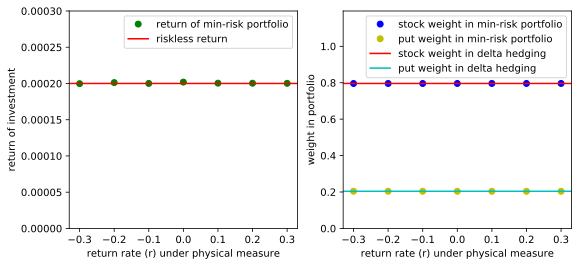

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 4))
# return of portfolio
ax = fig.add_subplot(1,2,1)
ax.plot(r_ps, reward_portfolio, 'og', label='return of min-risk portfolio')
ax.axhline(y=riskless_reward, color='r', linestyle='-', label='riskless return')
ax.set_ylim((0, riskless_reward*1.5))
ax.set_xlabel('return rate (r) under physical measure')
ax.set_ylabel('return of investment')
ax.legend(loc='best')
# weight of the stock and put
ax = fig.add_subplot(1,2,2)
ax.plot(r_ps, stock_ws_portfolio, 'ob', label='stock weight in min-risk portfolio')
ax.plot(r_ps, put_ws_portfolio, 'oy', label='put weight in min-risk portfolio')
ax.set_xlabel('return rate (r) under physical measure')
ax.axhline(y=w_stock_delta_hedging, color='r', linestyle='-', label='stock weight in delta hedging')
ax.axhline(y=w_put_delta_hedging, color='c', linestyle='-', label='put weight in delta hedging')
ax.set_ylim((0, w_stock_delta_hedging*1.5))
ax.set_ylabel('weight in portfolio')
ax.legend(loc='best')

## Conclusoin

This small excersise demonstrate that delta-hedge is indeed reproduced during efficient frontier construction, using PyMCEF.